# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109B Data Science 2: Advanced Topics in Data Science 
## Lab 7: Autoencoders

**Harvard University**<br>
**Spring 2020**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Angelaki Kaxiras<br>
**Content:** Eleni Angelaki Kaxiras, Vivek Hv, Cedric Flamant, and Pavlos Protopapas

---

In [53]:
# RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

<div class="discussion"><b>Welcome to our New Virtual Classroom!!</b> 
    
Chris Tanner, myself, and the lab TFs, have very much enjoyed your participation during our previous on-campus lab meetings, and will try to maintain interactivity via this new medium as best as we can. You can also do your part by:
    
- using your real name, if possible, so as to recreate a classroom feeling :)
- turning off your video to conserve bandwith 
- muting your microphone unless you are invited to speak 
- **raising your hand** in the Chat when we invite questions
- writing comments and questions in the Chat
    
If you have any questions after the lab is done, please post them on **Ed**, in the Lab7 section.
    
</div>

## Learning Goals

By the end of this lab, you should be able to:

- Connect the representation that Principal Component Analysis produces to the that of an autoencoder (AE).
- Add tf.keras Functional API into your machine learning arsenal.
- Implement an autoencoder using `tf.keras`:
    - build the encoder network/model
    - build the decoder network/model
    - decide on the latent/bottleneck dimension
    - train your AE
    - predict on unseen data
    
### Note: To see solutions, uncomment and run the following: 

```
# %load solutions/exercise2.py
```

First time you run will load solution, then you need to **run the cell again** to actually run the code.

<a id=top></a> 

## Table of Contents

- **Part 1**: [Autoencoders and their connection to Principal Component Analysis](#part1).
- **Part 2**: [Denoising Images using AEs](#part2).
- **Part 3**: [Visualizing Intermediate Layers of an AE](#part3).

In [54]:
from __future__ import annotations
import numpy as np
import seaborn as sns
import os
import datetime

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
%matplotlib inline

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D,\
                                    Dropout, Flatten, Activation, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Precision, Recall, FalsePositives, \
                                     FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2

In [56]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.
print(tf.__version__)  # You should see a > 2.0.0 here!
from tf_keras_vis.utils import print_gpus
print_gpus()

2.0.0
0 GPUs


In [57]:
# set the seed for reproducability of results
seed = 109
np.random.seed(seed)
tf.random.set_seed(seed)

In [58]:
# install this if you want to play around with Tensorboard
#!pip install tf-keras-vis tensorflow
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [59]:
# remove old logs
!rm -rf ./logs/ 

<a id=part1></a> 

## Part 1:  Autoencoders and the connection to Principal Component Analysis 

#### Principal Component Analysis (PCA)

**PCA** decomposes a multivariate dataset in a set of eigenvectors - successive orthogonal coeefficients that explain a large amount of the variance. By using only a number of the highest valued vectors, let's say $N$ of them, we effectively reduce the dimensionality of our data to $N$ with minimal loss of information as measured by RMS (Root Mean Squared) Error.  

PCA in `sklearn` is a transformer that learns those $N$ components via its `.fit` method. It can then be used to project a new data object in these components. Remember from 109a that we always `.fit` only to the training set and `.transform` both training and test set.

```
from sklearn.decomposition import PCA
k = 2 # number of components that we want to keep

X_train, X_test = load_data()
pca = PCA(n_components=k)

principal_components = pca.fit_transform(X_train)
principal_components = pca.transform(X_test)
```

#### Autoencoders (AE)

![svhn](../images/AE_Collet.jpg)

*image source: Deep Learning by Francois Collet*

An **AE** maps its input, usually an image, to a latent vector space via an encoder function, and then decodes it back to an output that is the same as the input, via a decoder function. It’s effectively being trained to reconstruct the original input. By trying to minimize the reconstruction MSE error, on the output of the encoder, you can get the autoencoder to learn interesting latent representations of the data. Historically, autoencoders have been used for tasks such as dimentionality reduction, feature learning, and outlier detection. 

One type of architecture for an AE is to have the decoder network be a 'mirror image' of the encoder. It makes more sense this way but it is not necessary. 

We can say that AEs are self-supervised learning networks! 


#### Understandind the connection between PCA and AEs 

If the hidden and output layers of an autoencoder are linear, the autoencoder will learn hidden units that are linear representations of the data, just like PCA does. If we have $M$ hidden units in our AE, those will span the same space as the $M$ first principal components. The hidden layers of the AE will not produce orthogonal representations of the data as PCA would but if we add non-linear components in our encoder-decoder networks we can represent a non-linear space/manifold; 

#### Fashion-MNIST

We will use the dataset of clothing article images (created by [Zalando](https://github.com/zalandoresearch/fashion-mnist)), consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a **28 x 28** grayscale image, associated with a label from **10 classes**. The names of the classes corresponding to numbers 0-9 are: 
```
'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', and 'Ankle boot'
```
The creators intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. Each pixel is 8 bits so its value ranges from 0 to 255.

Let's load and look at it!

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


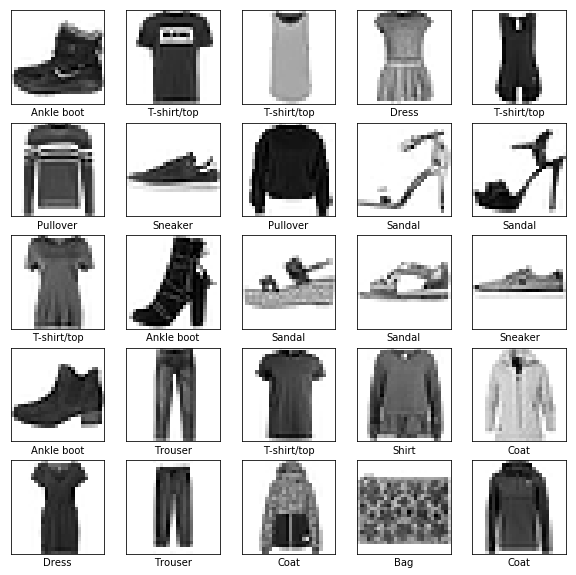

In [60]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data splitted in train and test! how nice!
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

# classes are named 0-9 so define names for plotting clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

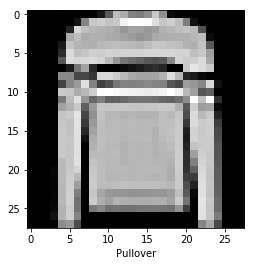

In [61]:
# choose one image to look at
i = 5
plt.imshow(X_train[i], cmap='gray');
plt.xlabel(class_names[y_train[i]]);

<div class="exercise"><b>Exercise 1:</b>  Calculate the dimensionality of the Fashion dataset. Then flatten it to prepare for PCA.</div>

In [62]:
## your code here


In [63]:
# %load solutions/exercise1.py
n_samples, h, w = X_train.shape
print(f'We have {n_samples} data sample images, each with height: {h} and width: {w}')
print(f'Data dimensionality: {h*w}')
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

# Flatten images for PCA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print(f'X_train flattened shape: {X_train_flat.shape}, X_test flattened shape: {X_test_flat.shape}')


We have 60000 data sample images, each with height: 28 and width: 28
Data dimensionality: 784
X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)
X_train flattened shape: (60000, 784), X_test flattened shape: (10000, 784)


In [64]:
from sklearn.decomposition import PCA

<div class="exercise"><b>Exercise 2:</b> Find the 2 first principal components by fitting on the train set. Print the shape of the components matrix.</div>

In [65]:
# your code here


Shape of the 2 component vector (First and Second): (2, 784)
Shape of first PC: (784,)
Shape of second PC: (784,)
Shape of reshaped eigenclothes: (2, 28, 28), shape of the first article of eigenclothing: (28, 28)


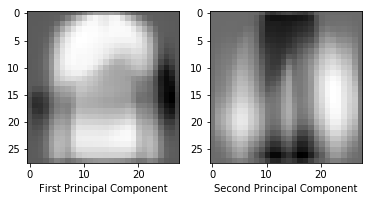

In [66]:
# %load solutions/exercise2.py
# Let's find the first 2 PCA components
num_components = 2
pca = PCA(n_components=num_components).fit(X_train_flat)

# take a look at them
print(f'Shape of the 2 component vector (First and Second): {pca.components_.shape}')
print(f'Shape of first PC: {pca.components_[0].shape}')
print(f'Shape of second PC: {pca.components_[0].shape}')

# reshape so they resemble images and we can print them
eigenclothes = pca.components_.reshape((num_components, h, w))
print(f'Shape of reshaped eigenclothes: {eigenclothes.shape}, shape of the first article of eigenclothing: {eigenclothes[0].shape}')

# show the reshaped principal components (eigenclothes)
f, ax = plt.subplots(1,2)
ax[0].imshow(eigenclothes[0], cmap='gray');
ax[0].set_xlabel('First Principal Component');
ax[1].imshow(eigenclothes[1], cmap='gray');
ax[1].set_xlabel('Second Principal Component');


In [67]:
# print the variance explained by those components
pca.explained_variance_

array([19.80980567, 12.11221047])

**Note:** The first two components explain ~19+12 = 31% of the variance.

<div class="discussion"><b>Discussion: </b> Comment on what you see here.</div>

In [68]:
# transform the train and test set
X_train_pca = pca.transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [69]:
X_train_pca.shape, X_train_pca[1:5,0].shape

((60000, 2), (4,))

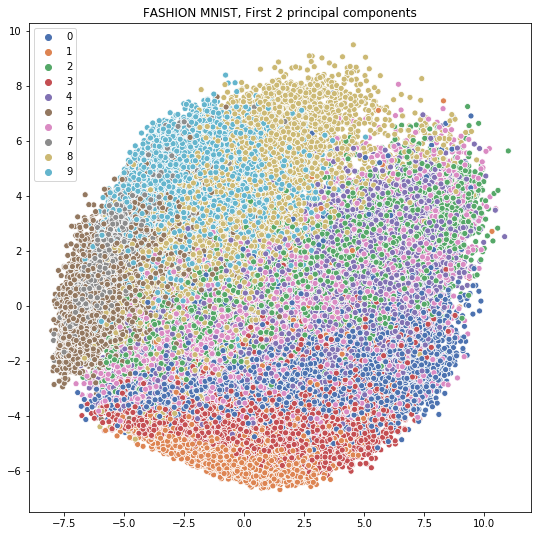

In [70]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax1 = plt.subplots(1,1, figsize=(9,9))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train,
                palette=sns.color_palette("deep", 10),  ax=ax1)
ax1.set_title("FASHION MNIST, First 2 principal components");

<a id=part2></a>

## Part 2:  Denoise Images using AEs

We will create an autoencoder which will accept "noisy" images as input and try to produce the original images. Since we do not have noisy images to start with, we will add random noise to our Fashion-MNIST images. To do this we will use the image augmentation library [imgaug docs](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html). 

From this library we will use `SaltAndPepper`, an augmenter which replaces pixels in images with salt/pepper noise (white/black-ish colors), randomly with probability passed as parameter `p`. Use the code below to install the library in your virtual environment.

In [71]:
# !conda install imgaug 
# ### OR
# !pip install imgaug

In [72]:
from imgaug import augmenters

In [85]:
# NNs want the inputs to be 4D
X_train = X_train.reshape(-1, h, w, 1)
X_test = X_test.reshape(-1, h, w, 1)

# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(p=0.1, seed=seed)
seq_object = augmenters.Sequential([noise])

# Augment the data (add the noise)
X_train_n = seq_object.augment_images(X_train * 255) / 255
X_test_n = seq_object.augment_images(X_test * 255) / 255

In [ ]:
f, ax = plt.subplots(1,5, figsize=(20,10))
for i in range(5,10):
    ax[i-5].imshow(X_train_n[i, :, :, 0].reshape(28, 28), cmap=plt.cm.binary)
    ax[i-5].set_xlabel('Noisy '+class_names[y_train[i]])
    
f, ax = plt.subplots(1,5, figsize=(20,10))
for i in range(5,10):
    ax[i-5].imshow(X_train[i, :, :, 0].reshape(28, 28), cmap=plt.cm.binary)
    ax[i-5].set_xlabel('Clean '+class_names[y_train[i]])

#### `tf.keras.Sequential` API

This is what we have been using so far for building our models. Its pros are: it's simple to use, it allows you to create models layer-by-layer. Its basic con is: it is not very flexible, and although it includes layers such as Merge, Concatenate, and Add that allow for a combination of models, it is difficult to make models with many inputs or shared-layers. All layers, as the name implies, are connected sequentially.

#### Intro to `tf.keras.Functional` API

https://www.tensorflow.org/guide/keras/functional. 

In this API, layers are built as graphs, with each layer indicating to which layer it is connected. Functional API helps us make more complex models which include non-sequential connections and multiple inputs or outputs.

Let's say we have an image input with a shape of (28, 28, 1) and a classification task:

```
num_classes = 10

inputs = keras.Input(shape=(h, w, 1))
x = Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax', name='output')(x)

ae_model = Model(inputs=inputs, outputs=outputs, name='autoencoder')

ae_model.summary()
```



#### Create the Encoder

In [75]:
# input layer
input_layer = Input(shape=(h, w, 1))

<div class="exercise"><b>Exercise 3:</b> Create your "encoder" as a 2D CNN a follows: </div>

- Use the Functional API
- Create  a pair of layers consisting of a `Conv2D` and a `MaxPool` layer which takes in our `input_layer`. Choose the number of filters. 
- Stack 3 of these layers, one after the other.
- Give this model the name `latent_model` (it's not your final model).


In [76]:
# your code here


In [77]:
# %load solutions/exercise3.py

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPooling2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPooling2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPooling2D( (2, 2), padding='same', name='latent_view')(encoded_layer3)

# call this the "encoder", we will use it later
encoder  = Model(input_layer, latent_view, name='encoder_model')


<div class="exercise"><b>Exercise 4:</b> Create your "decoder" as a 2D CNN as follows: </div>

- repeat the structure of your encoder but in "reverse".
- What is the output layer activation function? What are the dimensions of the output? 


In [78]:
# your code here


In [79]:
# %load solutions/exercise4.py
# decoding architecture
decoded_layer1 = Conv2D(4, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
# Note that the loss will be computed after every batch between the predicted output pixel and 
# the ground truth pixel using mean squared error pixel by pixel:
output_layer   = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded_layer3)


<div class="exercise"><b>Exercise 5:</b> Connect the two parts (encoder, decoder) to create your autoencoder. Compile  and then train your autoencoder.</div>

Choose an optimizer and a loss function. Use Early Stopping. To get good results you will need to run this about 20 epochs and this will take a long time depending on your machine. **For the purposes of this lab run only for 2 epochs**.

(Optional: add Tensorboard). 

Here is how to connect the two models:

In [80]:
# create the model
ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           1156      
_________________________________________________________________
latent_view (MaxPooling2D)   (None, 4, 4, 4)           0  

In [81]:
# your code here


In [82]:
# %load solutions/exercise5-1.py
loss = keras.losses.mse
optimizer = Adam() #RMSprop(learning_rate=0.001)
metrics = ['accuracy'] 

ae_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 


In [83]:
# %load solutions/exercise5-2.py
batch_size = 1048
epochs = 2 # do 2 for now, 20 when you have time

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [ tf.keras.callbacks.EarlyStopping(
                    # Stop training when `val_loss` is no longer improving
                    monitor= 'val_loss',
                    # "no longer improving" being further defined as "for at least `patience` epochs
                    patience=10,
                    verbose=5, mode='auto'),
             tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
            ]

history = ae_model.fit(X_train_n, X_train, epochs=epochs, batch_size=batch_size, 
                      validation_data=(X_test_n, X_test), callbacks=callbacks)


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
 8384/60000 [===>..........................] - ETA: 4:29 - loss: 0.1660 - accuracy: 0.4303WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [ ]:
# Let's see how our AE did 
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Val')
ax.set_xlabel("Epoch", fontsize=20)
ax.set_ylabel("Loss", fontsize=20)
ax.legend()
ax.set_title('Autoencoder Loss')

In [ ]:
# start Tensorboard - requires grpcio>=1.24.3
#%tensorboard --logdir logs

In [ ]:
# save your model
ae_model.save_weights('ae_model.h5')

<a id=part3></a> 

## Part 3: Visualizing Intermediate Layers of AE

<div class="exercise"><b>Exercise 6:</b> Let's now visualize the latent layer of our encoder network. </div>

This is our "encoder" model which we have saved as:
```
encoder  = Model(input_layer, latent_view, name='encoder_model')
```

In [ ]:
# your code here


In [ ]:
# %load solutions/exercise6.py
# plot the original noisy images
n = np.random.randint(0,len(X_test)-5)
f, ax = plt.subplots(1,5,figsize=(20,10))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(X_test_n[a, :, :, 0].reshape(28, 28), cmap='gray')
plt.show()

# print the predictions
preds = encoder.predict(X_test_n[n:n+5])
print(f'Shape of the predictions matrix: {preds.shape}')

latent_channels = 4

f, ax = plt.subplots(latent_channels,5, figsize=(20,10))
ax = ax.ravel()
for j in range(latent_channels):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, j], cmap='gray')
plt.show()


<div class="discussion"><b>Discussion</b>: 
    <li> What do you see in the little images above?</li>
<li> Could we have included Dense layers as bottleneck instead of just  Conv2D and MaxPoool/upsample?</li></div>

#### possible answers
We can have bottleneck layers in convolutional autoencoders that are not dense but simply a few stacked featuremaps such as above. They might have better generalizability due to only using shared weights. One interesting consequence is that without the dense layer you'll force translational equivariance on the latent representation (a particular feature in the top right corner will appear as an activation in the top right corner of the featuremaps at the level of the bottleneck, and if the feature is moved in the original image the activation in the bottleneck will move proportionally in the same direction). This isn't necessarily a problem, but you are enforcing some constraints on the relationships between the latent space directions that you wouldn't be with the presence of a dense layer.

### Visualize Samples reconstructed by our AE

In [ ]:
n = np.random.randint(0,len(X_test)-5)

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(X_test[a, :, :, 0].reshape(28, 28), cmap='gray')

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(X_test_n[a, :, :, 0].reshape(28, 28), cmap='gray')

In [ ]:
preds = ae_model.predict(X_test_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28), cmap='gray')
plt.show()

<div class="discussion"><b>Discussion:</b> Comment on the predictions.</div>